# Chatbot with Profile Schema 

## Review

We introduced the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We built a simple chatbot that uses both short-term (within-thread) and long-term (across-thread) memory.

This saved long-term semantic (facts about the user) memories ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories-in-the-hot-path), as the user is chatting with it.

## Goals

Our chatbot saved memories to the [store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) in the simplest possible way. 

First, it wrote memories as a string that simply overwrites the previous memory. In practice, we often want memories to have a particular structure, and ensure that there is no information loss over time. 

Second, it wrote based upon a user-provided keyword (`remember`). In practice, we often want the chatbot to decide when to save a memory rather than relying on the user to explicitly tell it. 

Let's address these shortcomings, starting here with the first.
 
Here, we'll use a schema to save memories and show a useful library, [Trustcall](https://github.com/hinthornw/trustcall), for updating schemas. 

In [7]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall

In [1]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Defining a memory schema

The [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) supports any schema for the `value` part of the key-value pair. 

This allows you to store structured information in the memory store. 

Python has many different types for [structured data](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition). 

### JSON Schema

The simplest and most common format for structured output is a JSON-like structure.

In Python, this can be represented as a dictionary (dict) or list (list). 

JSON objects (or dicts in Python) are often used directly when the tool requires raw, flexible, and minimal-overhead structured data.


In [ ]:
# JSON Schema
simple_user_schema = {
"type": "object",
"properties": {
    "content": {
        "type": "string",
        "description": "The main content of the memory. For example: User expressed interest in learning about French."
    },
    "context": {
        "type": "array",
        "items": {"type": "string"},
        "description": "Additional context for the memory. For example: This was mentioned while discussing career options in Europe.",
    }
}
}


Each field has a `type` and a `description`.

We can create an instance of this schema and save it to the memory store.

### Pydantic Schema

As a second example, [Pydantic](https://docs.pydantic.dev/latest/) is particularly useful for defining structured output schemas.

It offers type hints and validation. Here's an example of a Pydantic schema:

In [2]:
# Pydantic Schema

from pydantic import BaseModel, Field
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")
    context: str = Field(description="Additional context for the memory. For example: This was mentioned while discussing career options in Europe.")

### Saving a schema to the store

Let's save an instance of this schema to the memory store.

In [3]:
# JSON Schema
user_instance_json = {
    "content": "I'm Lance",
    "context": "Mentioned as an introduction to the chat."
}

# Pydantic Schema
user_instance_pydantic = Memory(content="I'm Lance", 
                                context="Mentioned as an introduction to the chat.")

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save an object to the store by namespace and key.

In [5]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = user_instance_json
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = user_instance_pydantic
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

We can see that the different schemas are saved their own keys.

In [6]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'content': "I'm Lance", 'context': 'Mentioned as an introduction to the chat.'}, 'key': '7022fd13-eaa2-4503-a96e-c293daa64eea', 'namespace': ['1', 'memories'], 'created_at': '2024-10-25T20:40:11.323604+00:00', 'updated_at': '2024-10-25T20:40:11.323607+00:00'}
{'value': Memory(content="I'm Lance", context='Mentioned as an introduction to the chat.'), 'key': '8258e862-37ef-445d-8ed1-433586439ad9', 'namespace': ['1', 'memories'], 'created_at': '2024-10-25T20:40:11.323699+00:00', 'updated_at': '2024-10-25T20:40:11.323700+00:00'}


## Writing schemas

The concept of [tool calling](https://python.langchain.com/docs/concepts/tool_calling/) allows models to write [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition) (e.g., a schema).

In [ ]:
_set_env("OPENAI_API_KEY")

In [11]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind Memory schema as a tool to the model
model_with_tools = model.bind_tools([Memory])

# Invoke the model
output = model_with_tools.invoke([HumanMessage("Hi!.")])
output.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [12]:
# Invoke the model with personal information, which should trigger the tool call
output = model_with_tools.invoke([HumanMessage("My name is Lance, I like to bike.")])
output.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_f4uDHsj1uFNLN14x3GYgJzzy)
 Call ID: call_f4uDHsj1uFNLN14x3GYgJzzy
  Args:
    content: User's name is Lance and he likes to bike.
    context: User introduced himself and shared his interest in biking.


In [16]:
output.tool_calls[0]["args"]

{'content': "User's name is Lance and he likes to bike.",
 'context': 'User introduced himself and shared his interest in biking.'}

## Error handling and updating

While models can be very good at extracting information from unstructured text, [they can also make mistakes](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema).

While working on memory over the past few months, we've experienced these problems first-hand: 

1. Extraction can become error-prone as the schema gets more complex.
2. Information loss can occur when updating a schema, especially if the schema contains a lot of information or has a complex structure.

One of the engineers on the LangChain team, [Will Fu-Hinthorn](https://github.com/hinthornw) created the [TrustCall](https://trustcall.langchain.com/) library to help address these problems.

Let's show an example, starting with a simple schema for a user profile.

In [37]:
from pydantic import BaseModel

class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

Now, let's create a conversation that we want to use to create the user profile.

In [38]:
conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco."""

We can create an extractor for this schema with TrustCall.

In [39]:
from trustcall import create_extractor

trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile",
)

# Instruction
instruction = f"""Extract the user profile from the following conversation:
<convo>
{conversation}
</convo>"""

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=instruction)]})
existing_profile = result["responses"][0]
existing_profile

UserProfile(user_name='Lance', user_location='San Francisco', interests=['biking'])

In [40]:
existing_profile.model_dump()

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['biking']}

One primary benefit of Trustcall is that it will seamlessly check schema validation and handle re-tries for you.

The central intuition behind Trustcall is that it prompts the model to produce [JSON Patch](https://jsonpatch.com/) to correct schema validation errors.

This is both more reliable than naive re-prompting and cheaper since you only regenerate a subset of the full schema.

JSON patches are *also* address the problem of information loss when updating a schema! 

Rather than naively re-generating the full output, it prompts the LLM to generate a concise patch to update the schema.

Let's see updating in action.

In [42]:
# Update the conversation
updated_conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco.
Assistant: San Francisco is a great city! Where do you go after biking?
User: I really like to go to a bakery."""

# Update the instruction
updated_instruction = f"""Update the memory (JSON doc) to incorporate new information from the following conversation:
<convo>
{updated_conversation}
</convo>"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=updated_instruction)], 
                                     "existing": {"UserProfile": existing_profile.model_dump()}})
updated_profile = result["responses"][0]
updated_profile

UserProfile(user_name='Lance', user_location='San Francisco', interests=['biking', 'going to a bakery'])

In [43]:
updated_profile.model_dump()

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['biking', 'going to a bakery']}

## Chatbot that uses TrustCall to format and update memories

Now, let's use the store in a simple chatbot that saves memories. 

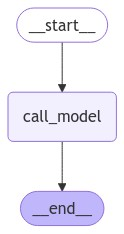

In [65]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the profile from the store using the key that we save the profile under
    profile = store.get(namespace, "user_profile")

    # Get the last message from the user 
    last_message = state["messages"][-1]

    # Check if it contains the keyword "remember"
    if "remember" in last_message.content.lower():
        
        # Get the profile as the value from the list, and convert it to a JSON doc
        existing_profile = {"UserProfile": profile.value} if profile else None

        # Instructions 
        instruction = f"""Create or update the memory (JSON doc) to incorporate information from the following conversation:
        <convo>
        {list(state['messages'])}
        </convo>"""
        
        # Invoke the extractor
        result = trustcall_extractor.invoke({"messages": [HumanMessage(content=instruction)], "existing": existing_profile})
        
        # Get the updated profile
        updated_profile = result["responses"][0].model_dump(mode="json")

        # Save the updated profile
        key = "user_profile"
        store.put(namespace, key, {"profile": updated_profile})

    # Format all memories for the system prompt
    system_msg = f"You are a helpful assistant. Here is relevant information about the user: {profile.value if profile else None}"
    
    # Invoke the model with the system prompt that contains the memories as well as the user's messages
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])
    return {"messages": response}

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", END)

# Store from cross-thread memory
in_memory_store = InMemoryStore()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=MemorySaver(), store=in_memory_store)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [66]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "4", "user_id": "1"}}

# I give the chatbot a message to remember using the keyword "remember"
input_messages = [HumanMessage(content="Hi! Remember: my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Remember: my name is Lance
================================== Ai Message ==================================

Hi Lance! How can I assist you today?


In [67]:
# Continue the conversation
input_messages = [HumanMessage(content="Remember: I like to bike")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Remember: I like to bike
================================== Ai Message ==================================

Got it, Lance! You like to bike. Do you have any biking-related questions or topics you'd like to discuss?


In [69]:
# Define the namespace for the memories
namespace = ("memories", "1")

# Retrieve the profile from the store using the key that we save the profile under
profile = in_memory_store.get(namespace, "user_profile")
profile.dict()

{'value': {'profile': {'user_name': 'Lance',
   'user_location': '',
   'interests': ['bike']}},
 'key': 'user_profile',
 'namespace': ['memories', '1'],
 'created_at': '2024-10-25T22:48:46.305930+00:00',
 'updated_at': '2024-10-25T22:48:53.747877+00:00'}

In [70]:
# Continue the conversation
input_messages = [HumanMessage(content="Remember: I live in San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Remember: I live in San Francisco
================================== Ai Message ==================================

Sure thing, Lance! You live in San Francisco. If you need any information or recommendations related to biking in the area, feel free to ask!


In [71]:
# Define the namespace for the memories
namespace = ("memories", "1")

# Retrieve the profile from the store using the key that we save the profile under
profile = in_memory_store.get(namespace, "user_profile")
profile.dict()

{'value': {'profile': {'user_name': 'Lance',
   'user_location': 'San Francisco',
   'interests': ['bike']}},
 'key': 'user_profile',
 'namespace': ['memories', '1'],
 'created_at': '2024-10-25T22:48:46.305930+00:00',
 'updated_at': '2024-10-25T22:51:02.175359+00:00'}

We can see that the profile is being updated as we continue the conversation!

## LangSmith 

We can view the chatbot's memory updates in LangSmith, and in particular see how TrustCall is used to update the memory.

https://smith.langchain.com/public/c422bbba-1320-4df6-853a-e654ca0ef5c9/r